# Log Server Analysis

This is the assignment **#1** related to **Machine Learning** section of the **Artificial Intelligence** course at **Shahid Beheshti University**. ([Course repository link](https://github.com/SBU-CE/Artificial-Intelligence)).

In this notebook, we will take advantage of three principal python libraries for data science and machine learning tasks.

 - [Numpy](https://numpy.org): The fundamental package for **scientific computing** with Python.
 - [Pandas](https://pandas.pydata.org): An open source **data analysis and manipulation tool**, built on top of the Python programming language.
 - [Matplotlib](https://matplotlib.org) : A comprehensive library for **creating static, animated, and interactive visualizations** in Python.
 
 
 **Before you start:** Please read the ***Submission*** section at the bottom of the notebook carefully.

# 0. What Is Log Analysis & Why Is It Important? 

**Log analysis** is the process of making sense of computer-generated log messages, also known as log events, audit trail records, or simply logs. Most businesses are required to archive and analyze logs of their websites requests from their clients as part of their compliance regulations. 

They must regularly perform system log monitoring and analysis to search for **errors**, **anomalies**, or **suspicious** or **unauthorized activity** that deviates from the norm. Log analysis allows them to re-create the chain of events that led up to a problem and effectively troubleshoot it.

Web sever logs contain information on any event that was registered/logged. This contains a lot of insights on website visitors, behavior, crawlers accessing the site, business insights, security issues, and more.

## Data

In this notebook, we will use the 3.3GB of logs from an Iranian ecommerce website [zanbil.ir](zanbil.ir). 

**Acknowledgements**: 
Zaker, Farzin, 2019, "*Online Shopping Store - Web Server Logs*", https://doi.org/10.7910/DVN/3QBYB5, Harvard Dataverse, V1.

Please download the raw dataset `access.log` from https://www.kaggle.com/eliasdabbas/web-server-access-logs([~ 264MB]) and put it besides this notebook in the current directory.

So let's dive into it!

## Setup

We will heavily use NumPy, Pandas and Matplotlib libraries in this assignment. Notice that you are free to import other libraries in case they are needed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Convert a Log File Into an Efficient DataFrame

This first step is the prototype of a process of converting a log file to an efficient format on disk (Apache Parquet), and then to read it into an efficient DataFrame with optimized datatypes.

In this part we convert a 3.3 GB text file to a 256 MB parquet file, which is later read into a 297 MB DataFrame. The total time can vary between two to five minutes, depending on the system used. 

**Note**: Make sure to **sequentially run all the cells**, so that the intermediate variables / packages will carry over to the next cell.

In [2]:
# read some sample lines from the log file
!head -n 3 access.log

54.36.149.41 - - [22/Jan/2019:03:56:14 +0330] "GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C%DA%A9%D8%B3%D9%84,27|%DA%A9%D9%85%D8%AA%D8%B1%20%D8%A7%D8%B2%205%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C%DA%A9%D8%B3%D9%84,p53 HTTP/1.1" 200 30577 "-" "Mozilla/5.0 (compatible; AhrefsBot/6.1; +http://ahrefs.com/robot/)" "-"
31.56.96.51 - - [22/Jan/2019:03:56:16 +0330] "GET /image/60844/productModel/200x200 HTTP/1.1" 200 5667 "https://www.zanbil.ir/m/filter/b113" "Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build/HuaweiALE-L21) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.158 Mobile Safari/537.36" "-"
31.56.96.51 - - [22/Jan/2019:03:56:16 +0330] "GET /image/61474/productModel/200x200 HTTP/1.1" 200 5379 "https://www.zanbil.ir/m/filter/b113" "Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build/HuaweiALE-L21) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.158 Mobile Safari/537.36" "-"


## Log Format

This approach assumes the common log format and/or the combined one, which are two of the most commonly used. Eventually other formats can be incorporated. We start with the below regular expression taken from:

[Regular Expression Cookbook](https://www.oreilly.com/library/view/regular-expressions-cookbook/9781449327453/ch07s12.html)

by *Jan Goyvaerts, Steven Levithan*

Publisher: O'Reilly Media, Inc. Release Date: August 2012

In [2]:
# There is a minor bug in this regex, it misses the last field. we'll fix this soon. 

common_regex = '^(?P<client>\S+) \S+ (?P<userid>\S+) \[(?P<datetime>[^\]]+)\] "(?P<method>[A-Z]+) (?P<request>[^ "]+)? HTTP/[0-9.]+" (?P<status>[0-9]{3}) (?P<size>[0-9]+|-)'
combined_regex = '^(?P<client>\S+) \S+ (?P<userid>\S+) \[(?P<datetime>[^\]]+)\] "(?P<method>[A-Z]+) (?P<request>[^ "]+)? HTTP/[0-9.]+" (?P<status>[0-9]{3}) (?P<size>[0-9]+|-) "(?P<referrer>[^"]*)" "(?P<useragent>[^"]*)'
columns = ['client', 'userid', 'datetime', 'method', 'request', 'status', 'size', 'referer', 'user_agent']

## The Approach

* Loop through the lines of the input log file one by one. This ensures minimal memory consumption. 
* For each line, check it against the regular expression, and process it: 
  * Match: append the matched line to a `parsed_lines` list
  * No match: append the non-matching line to the `errors_file` for later analysis
* Once `parsed_lines` reaches 250,000 elements, convert the list to a DataFrame and save it to a `parquet` file in the `output_dir`. Clear the list. This also ensures minimal memory usage, and the 250k can be tweaked if necessary.
* Read all the files of the `output_dir` with `read_parquet` into a pandas DataFrame. This function handles reading all the files and combines them. 
* Optimize the columns by using more efficient data types, most notably the pandas categorical type.
* Write the DataFrame to a single file, for more convenient handling, and with the more efficient datatypes. This results in even faster reading.
* Delete the files in `output_dir`.
* Read in the final file with `read_parquet`.
* Happy log server analyzing!


In [3]:
# Create a destinatoin directory where output files will be stored
%mkdir parquet_dir

A subdirectory or file parquet_dir already exists.


In [5]:
# install some usefull packages for converting log file to parquet format

%pip install pyarrow --user
%pip install fastparquet --user

Note: you may need to restart the kernel to use updated packages.



## The `logs_to_df` Function

This function will convert the `access.log` file into an optimized `DataFrame` and also write the errors happend during converting (e.g. some lines of the log file are not following the common format of nginx log) intp `errors.txt`.

In [3]:
import time
import re
from tqdm import tqdm

def logs_to_df(logfile, output_dir, errors_file):
    with open(logfile) as source_file:
        linenumber = 0
        parsed_lines = []
        for line in tqdm(source_file):
            try:
                log_line = re.findall(combined_regex, line)[0]
                parsed_lines.append(log_line)
            except Exception as e:
                with open(errors_file, 'at') as errfile:
                    print((line, str(e)), file=errfile)
                continue
            linenumber += 1
            if linenumber % 250_000 == 0:
                df = pd.DataFrame(parsed_lines, columns=columns)
                df.to_parquet(f'{output_dir}/file_{linenumber}.parquet')
                parsed_lines.clear()
        else:
            df = pd.DataFrame(parsed_lines, columns=columns)
            df.to_parquet(f'{output_dir}/file_{linenumber}.parquet')
            parsed_lines.clear()

In [4]:
# Times will vary from system to system, and I will use the approximate values, 
# so when you read this, you will likely see slightly different numbers.

%time logs_to_df(logfile='access.log', output_dir='parquet_dir/', errors_file='errors.txt')

10365152it [01:09, 150096.28it/s]


Wall time: 1min 9s


Actually we are now ready to start analysis, as we have the parquet files that can be read. But we will optimize them even more.

Just let's check the number of resulting parsing errors:

In [7]:
!wc errors.txt

   1435   35185 1141840 errors.txt


Now we are able to read the whole parquet files. Reading the whole directory takes about nine seconds. We now check the size of the resulting directory on disk:

In [5]:
%time logs_df = pd.read_parquet('parquet_dir/')

Wall time: 13.7 s


In [6]:
!du -sh parquet_dir/

257M	parquet_dir/


256 ÷ 3,300 = 0.07.

The resulting file is **7%** the size of the original!

Let's see how much memory it takes:

In [12]:
logs_df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10364865 entries, 0 to 10364864
Data columns (total 9 columns):
 #   Column      Non-Null Count     Dtype 
---  ------      --------------     ----- 
 0   client      10364865 non-null  object
 1   userid      10364865 non-null  object
 2   datetime    10364865 non-null  object
 3   method      10364865 non-null  object
 4   request     10364865 non-null  object
 5   status      10364865 non-null  object
 6   size        10364865 non-null  object
 7   referer     10364865 non-null  object
 8   user_agent  10364865 non-null  object
dtypes: object(9)
memory usage: 711.7+ MB


711 MB. We now can remove the files in `parquet_dir` and optimize the datatypes and use more efficient ones. 

**Note**: You can keep it for later usages. Since the kernel will die after you terminate the notebook, the dataframe will be removed from memory.

In [18]:
!rm -r parquet_dir/

rm: cannot remove 'parquet_dir/': No such file or directory


Now we optimize the dataframe by changing the column data types. It may take a few seconds:

In [14]:
logs_df['client'] = logs_df['client'].astype('category')
del logs_df['userid']
logs_df['datetime'] = pd.to_datetime(logs_df['datetime'], format='%d/%b/%Y:%H:%M:%S %z')
logs_df['method'] = logs_df['method'].astype('category')
logs_df['status'] = logs_df['status'].astype('int16')
logs_df['size'] = logs_df['size'].astype('int32')
logs_df['referer'] = logs_df['referer'].astype('category')
logs_df['user_agent'] = logs_df['user_agent'].astype('category')

**Note**: Some types are considered as `Categorical`. (client, method, referer and user_agent). You may need to convert them to *string* in some questions.

In [15]:
logs_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10364865 entries, 0 to 10364864
Data columns (total 8 columns):
 #   Column      Non-Null Count     Dtype                                
---  ------      --------------     -----                                
 0   client      10364865 non-null  category                             
 1   datetime    10364865 non-null  datetime64[ns, pytz.FixedOffset(210)]
 2   method      10364865 non-null  category                             
 3   request     10364865 non-null  object                               
 4   status      10364865 non-null  int16                                
 5   size        10364865 non-null  int32                                
 6   referer     10364865 non-null  category                             
 7   user_agent  10364865 non-null  category                             
dtypes: category(4), datetime64[ns, pytz.FixedOffset(210)](1), int16(1), int32(1), object(1)
memory usage: 342.3+ MB


The file was reduced further from 711 to 298 MB. (342 ÷ 711 = 0.42 of the original size).

We now save it to a single file, and read again.

In [15]:
logs_df.to_parquet('logs_df.parquet')

## Read the Parquet file into a DataFrame

In [16]:
# Read the optimized parquet file into a dataframe
logs_df = pd.read_parquet('logs_df.parquet')

print ('DataFrame shape: {}'.format(logs_df.shape))
logs_df.head(10)

DataFrame shape: (10364865, 8)


,client,datetime,method,request,status,size,referer,user_agent
0,37.152.163.59,2019-01-22 12:38:27+03:30,GET,/image/29314?name=%D8%AF%DB%8C%D8%A8%D8%A7-7.j...,200,1105,https://www.zanbil.ir/product/29314/%DA%A9%D8%...,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....
1,37.152.163.59,2019-01-22 12:38:27+03:30,GET,/static/images/zanbil-kharid.png,200,358,https://www.zanbil.ir/product/29314/%DA%A9%D8%...,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....
2,85.9.73.119,2019-01-22 12:38:27+03:30,GET,/static/images/next.png,200,3045,https://znbl.ir/static/bundle-bundle_site_head...,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
3,37.152.163.59,2019-01-22 12:38:27+03:30,GET,/image/29314?name=%D8%AF%DB%8C%D8%A8%D8%A7-4.j...,200,1457,https://www.zanbil.ir/product/29314/%DA%A9%D8%...,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....
4,85.9.73.119,2019-01-22 12:38:27+03:30,GET,/static/images/checked.png,200,1083,https://znbl.ir/static/bundle-bundle_site_head...,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
5,37.152.163.59,2019-01-22 12:38:27+03:30,GET,/static/images/loading.gif,200,7370,https://www.zanbil.ir/product/29314/%DA%A9%D8%...,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....
6,77.245.233.52,2019-01-22 12:38:27+03:30,GET,/image/11082/productType/240x180,200,12458,https://www.zanbil.ir/browse/sports/%D8%AA%D8%...,Mozilla/5.0 (Windows NT 6.1; rv:64.0) Gecko/20...
7,37.27.128.139,2019-01-22 12:38:27+03:30,GET,/browse/Tablet-Arm-Chair/%D8%B5%D9%86%D8%AF%D9...,200,30604,https://www.zanbil.ir/browse/Classroom-Furnitu...,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...
8,77.245.233.52,2019-01-22 12:38:27+03:30,GET,/image/851/mainSlide,200,89859,https://www.zanbil.ir/browse/sports/%D8%AA%D8%...,Mozilla/5.0 (Windows NT 6.1; rv:64.0) Gecko/20...
9,77.245.233.52,2019-01-22 12:38:27+03:30,GET,/image/848/mainSlide,200,93168,https://www.zanbil.ir/browse/sports/%D8%AA%D8%...,Mozilla/5.0 (Windows NT 6.1; rv:64.0) Gecko/20...


# 2. Exploratory Data Analysis (EDA)

What's EDA? **Exploratory Data Analysis (EDA)** is an approach for data analysis that employs a variety of techniques (mostly graphical) to

  - Maximize insight into a data set.
  - Uncover underlying structure.
  - Extract important variables.
  - Detect outliers and anomalies.
  - Test underlying assumptions.
  
EDA is a primary task before each data-driven algorithms. Most EDA techniques are **graphical** in nature with a few quantitative techniques. The reason for the heavy reliance on graphics is that by its very nature the main role of EDA is to open-mindedly explore, and graphics gives the analysts unparalleled power to do so, enticing the data to reveal its structural secrets, and being always ready to gain some new, often unsuspected, insight into the data.

In this assignment, you will implement some of these methods step by step.

## Q1. Extract the most visited clients. (10 points)

What are the top n'th visited clients? Fill the function below to: 

   1. Return the top n'th visited IPs as `pandas.DataFrame`
   2. Plot them within a **horizontal bar chart**. You can use the matplotlib [documentation](https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html).

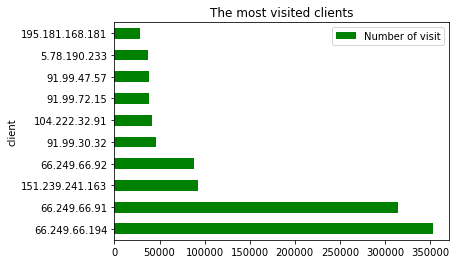

In [17]:
def top_clients(df, n=10):
    # TODO: Implement this function that takes a pd.DataFrame and n
    # as an integer number and returns the top n'th visited IPs(clients).
    # Also it must plot a horizontal bar chart with appropriate labels and colors.
    # Note that your code must work for all n's as input.
    
    top_n_visited_clients = pd.DataFrame()
    
    ############# Your code here ############
    top_n_freq_endpoints = df[['client','status']].groupby('client')['status'].count().reset_index(name='Number of visit').sort_values(['Number of visit'], ascending=False)
#     print(top_n_freq_endpoints.head(n))
    top_n_freq_endpoints.head(n).plot.barh(x='client', y='Number of visit',title='The most visited clients', color='green')
    #########################################
    
    return top_n_visited_clients


top_n_visited_clients = top_clients(logs_df, n=10)
assert type(top_n_visited_clients) == pd.DataFrame

## Q2. What are the most frequent endpoints? (10 points)

The `request` column in the main DataFrame is indicating the endpoints which clients has requested. Fill the function below to:

  1. Return the top n'th frequent endpoints as a `pandas.DataFrame`
  2. Plot them within a **Pie chart**. You can use the matplotlib [documentation](https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html) as well.

                                      request  frequent
0                              /settings/logo    352047
1           /static/css/font/wyekan/font.woff    280176
2     /static/images/guarantees/bestPrice.png    138010
3  /static/images/guarantees/fastDelivery.png    125689
4      /static/images/guarantees/warranty.png    124127


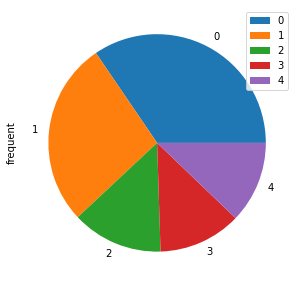

In [26]:
def top_endpoints(logs_df, n=5):
    # TODO: Implement this function that takes a pd.DataFrame and n
    # as an integer number and returns the top n'th frequent endpoints.
    # Also it must plot a pie bar chart with appropriate labels and colors.
    
    # Note that your code must work for all n's as input.
    
    top_n_freq_endpoints = pd.DataFrame()
    
    ############# Your code here ############
    top_n_freq_endpoints = logs_df[['request','status']].groupby('request')['status'].count().reset_index(name='frequent').sort_values(['frequent'], ascending=False)
    top_n_freq_endpoints.reset_index(drop=True, inplace=True)
    print(top_n_freq_endpoints.head(n))
    top_n_freq_endpoints.head(n).plot.pie(y='frequent', figsize=(5, 5))
    #########################################
    
    return top_n_freq_endpoints


top_n_freq_endpoints = top_endpoints(logs_df, n=5)
assert type(top_n_freq_endpoints) == pd.DataFrame

## Q3. More in Endpoints! (10 points)

In this question you **must** use **regex** to do some processing on endpoints (`request` column).

 1. Remove all the query parameters in the endpoints. e.g. `/image/29314?name=%D8%AF%DB%8C%D8%A8%D8%A7-4.js` must be transformed to `/image/29314.js`
 
 2. Then, what porportion of the endpoints including `/image` in their address, are really images? You can assume that images must only have `jpg`, `png`, `jpeg`, and `webp` extensions.

In [58]:
def image_endpoints(logs_df):
    # TODO: Implement this function that takes a pd.DataFrame
    # and returns the (i) a preprocessed logs_df DataFrame.
    # Also (ii) a float number between [0, 1] which indicates the porportion of endpoints including 
    # /image in their address being image files.

    # Note: For the first part have to use python regex and avoid any loops.
    
    real_img_percentage = 0.0
    
    ############# Your code here ############
    clear_query = logs_df['request'].str.split('?').str[0]
    is_img = clear_query.str.contains(pat = '/image')
    all_img = clear_query[is_img]
    is_real_img = all_img.str.contains(pat = 'jpg|png|jpeg|webp')
    real_img = all_img[is_real_img]
    real_img_percentage = real_img.size/all_img.size
    #print(real_img_percentage)
    #########################################
    
    return logs_df, real_img_percentage

preprocessed_df, real_img_percentage = image_endpoints(logs_df)
assert preprocessed_df.shape == logs_df.shape 
assert  real_img_percentage <= 1 and real_img_percentage >= 0

## Q4. What can we infer from the status codes? (15 points)

As we know, each request get a response code from the server which has it own meanings. Here is a summary for status code families definition:

 - **1xx**: An informational response indicates that the request was received and understood.
 - **2xx**: This class of status codes indicates the action requested by the client was received, understood, and accepted.
 - **3xx**: This class of status code indicates the client must take additional action to complete the request. Many of these status codes are used in URL redirection.
 - **4xx**: This class of status code is intended for situations in which the error seems to have been caused by the client
 - **5xx**: The server failed to fulfil a request.
 
 Read more about individual status codes [here](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes).
 
 
In this part, we want the **distribution** of each status codes has occured in the log file. Additionally we  want to notice that on which **hours** during a day the server may response to the client using error messages.

**Note**: In this question you may need to use `pandas.to_datetime`.

    status  frequency
0      200    9579824
1      206          3
2      301      67552
3      302     199835
4      304     340228
5      400        318
6      401        323
7      403       5634
8      404     105011
9      405          6
10     408        112
11     499      50852
12     500      14266
13     502        798
14     504        103


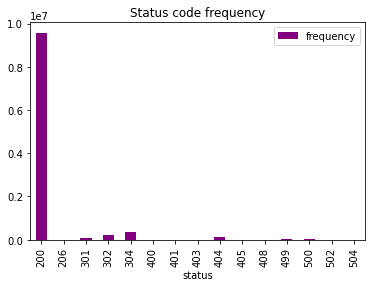

In [67]:
def status_codes_ditribution(logs_df):
    # TODO: Implement this function that takes a pd.DataFrame
    # and (i) return a python list of unique values of the status codes
    # and (ii) plot a vertical bar chart of status codes frequencies.
    
    status_codes_list = None
    
    ############# Your code here ############
    status_codes_list = logs_df['status'].unique()
    status_codes = pd.DataFrame()
    status_codes = logs_df[['status','client']].groupby('status')['client'].count().reset_index(name='frequency')
    print(status_codes)
    #print(status_codes_list)
    status_codes.plot.bar(x='status', y='frequency',title='Status code frequency', color='purple')
    #########################################
    
    return status_codes_list

status_codes_list = status_codes_ditribution(logs_df)

We want to create a DataFrame containing the total number of **4xx** and **5xx** responses for requests for each hour of the day. You must create a **2-column** DataFrame for each 4xx and 5xx families. This DataFrame must include **24 rows** which are corresponded to hours of a day.

The structure of desired DataFrame is as followes:

| hour | 4xx | 5xx | 
| --- | --- | --- |
| 0 | ... | ... |
| 1 | ... | ... |
| 2 | ... | ... |
| ... | ... | ... |
| 21 | ... | ... |
| 22 | ... | ... |
| 23| ... | ... |


In [19]:
def hourly_errors(logs_df):
    # TODO: Implement this function that takes a pd.DataFrame
    # and returns a 8x2 DataFrame described above (Duration is index)
    
    # Note: Remember that in this assignment(even in your Data-Science life!) you are not
    # allowed to use loops iterating over a DataFrame.
    
    errors_freq_df = pd.DataFrame()
    
    ############# Your code here ############
    df = logs_df
    df['datetime'] = df['datetime'].dt.hour
    df_status_4xx = df.loc[df['status'].apply(lambda x: x>=400 and x < 500 )]
    df_4xx = df_status_4xx[['datetime','status']].groupby('datetime')['status'].count().reset_index(name='4xx')
    df_status_5xx = df.loc[df['status'].apply(lambda x:  x >= 500 )]
    df_5xx = df_status_5xx[['datetime','status']].groupby('datetime')['status'].count().reset_index(name='5xx')
#     df_4xx = df[['datetime','status']].groupby('datetime')['status'].any(apply(lambda x: x>=400 and x< 500)).count().reset_index(name='4xx')
#     logs_df[['status','client','datetime']].groupby('status')['client'].count().reset_index(name='frequency')
    #print(df_5xx.drop('datetime',axis=1))
    df_4xx = df_4xx.drop('datetime',axis=1)
    df_5xx = df_5xx.drop('datetime',axis=1)
    errors_freq_df = pd.concat([df_4xx.reset_index(drop=True),df_5xx.reset_index(drop=True)], axis=1)
    errors_freq_df.index.names = ['hour']
#     print(errors_freq_df.shape)
    display(errors_freq_df)

    #########################################
    
    return errors_freq_df

errors_freq_df = hourly_errors(logs_df)
assert errors_freq_df.shape == (24, 2)

,4xx,5xx
hour,,
0,6021,17
1,4215,10
2,2394,8
3,1388,26
4,1871,3
5,1683,10
6,2036,3
7,2923,6
8,4985,76


## Q5. How can user agents help us to recognize bots readily? (10 points)

What is user agent? Please read [this](https://en.wikipedia.org/wiki/User_agent) in case you don't know!

There is a useful library called `user_agents`. It is a Python library that provides an easy way to identify/detect devices like mobile phones, tablets and their capabilities by parsing (browser/HTTP) user agent strings.

In [20]:
# Firstly, lets install it:
%pip install pyyaml ua-parser user-agents

Please visit it's [documentation](https://pypi.org/project/user-agents/) page.

In this part, we will create a DataFrame which has these columns **per each session** (we assume that each rows with same IPs and user agents are within a same session). You have to group the `logs_df` DataFrame by their `client` and `user_agent` columns.

This DataFrame columns are listed below:

 - Browser family: *string*
 - OS family: *is string*
 - Is_bot: *boolean* 
 - Is_pc: *boolean* 


In [38]:
from user_agents import parse 

def user_agent_details(logs_df):
    # TODO: Implement this function that takes a pd.DataFrame
    # and return a # of sessions x 4 DataFrame. 
    
    # Note: you must bind the user_agent functions to your DataFrame rows, hence you cannot use loops.
    
    user_agent_details_df = pd.DataFrame()
    
    ############# Your code here ############
    df = pd.DataFrame()
    df = logs_df[['client','user_agent']].groupby(['client','user_agent'],observed=True)
    browser_family_df = df['user_agent'].apply(pd.DataFrame).map(lambda x : parse(x).browser.family)
    os_family_df = df['user_agent'].apply(lambda x : parse(x).os.family)
    is_bot_df = df['user_agent'].apply(lambda x : parse(x).is_bot)
    is_pc_df = df['user_agent'].apply(lambda x : parse(x).is_pc)
    df = pd.concat([browser_family_df,os_family_df,is_bot_df,is_pc_df], axis=1)
    display(df.head(10))
    #########################################
    
    return user_agent_details_df

user_agent_details_df = user_agent_details(logs_df)

KeyboardInterrupt: 

## Q6. Take a deeper look! (10 points)

Extract all the rows of the table with:

    - client = '66.249.66.194'
    - user_agent = 'Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)'
    
Then answer the following questions:

   1. What percentage of the requests of these rows have `size = 0`?
   2. Take a look at the endpoints of the requests having `size = 0`. What substring do they have in common mostly?
   
Then fill the function below to plot a histogram for sizes of the requests.

In [ ]:
client = '66.249.66.194'
user_agent = 'Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)'

def plot_histogram(sample_df, n_bins=10):
    # TODO: Implement this function that takes a pd.DataFrame
    # and plot a histogram with n_bins bins.
    
    ############# Your code here ############
    
    #########################################
    
sample_df = logs_df[(logs_df['client'] == client) & (logs_df['user_agent'] == user_agent)]  
plot_histogram(sample_df, n_bins=10)

# 3. Feature Engineering

We now have some insights of the dataset. In this part we are going to create some new features to help us better classifying **web crawlers/bots** and normal clients.

In over the last decade, there have been numerous studies that have tried to classify web robots from web server access logs using Machine Learning approaches. But is it really possible to classify each requests individually? Nowdays, attackers and web crawler developers, implement bots which act broadly similar to humans! Therefore, it is not practical to classify the requests into crawlers and normal clients just based on one request. Here sessions just come in!

**Session definition**: A session is a group of user interactions(requests) with your website that take place within a given time frame. For simplicity, we assume that each session only corresponds to one client(IP) and we also ignore the time frame. 

Hence you can create the session DataFrame with grouping the logs DataFrame by `client` and `user_agent` columns.

## Q7. Write 10 features of web crawlers' access logs within a session which deviate them from normal client ones? Explain the intuition behind each one briefly? (5 points)

You are free to search on the internet and read previous studies in this area but **you must mention your sources in your report**. 

This paper can be helpful: *Detecting Web Crawlers from Web Server Access Logs with Data Mining*. [[PDF]](https://www.eecs.yorku.ca/course_archive/2019-20/F/6412/project/samples/Dusan-report.pdf)

## Q8. Create the session DataFrame (10 points)

Fill the function below to create the session DataFrame based on grouping the `logs_df` by `client` and `user_agent` columns. This DataFrame must contain one column which indicates the number of requests for each session named `requests_count`. Also **sort** the final DataFrame based on `requests_count` in **descending** order.


What can we imply from the user agents of the sessions with most request frequency? Are they normal clients? Write your thoughts in the report file.

In [ ]:
# change the data type of the client, user_agent, referer columns.
# It may take 1-2 minutes to execute.

logs_df['client'] = logs_df['client'].astype(str)
logs_df['user_agent'] = logs_df['user_agent'].astype(str)

In [ ]:
def create_session_df(logs_df):
    # TODO: Implement this function that takes a pd.DataFrame
    # and return the session DataFrame
    
    session_df = pd.DataFrame()
    
    ############# Your code here ############
    session_df = pd.DataFrame(logs_df.groupby(['client', 'user_agent']).size(), columns=['requests_count'])
    #########################################
    
    return session_df.sort_values('requests_count', ascending=False)

session_df = create_session_df(logs_df)
assert session_df.shape == (295087, 1)

## Q9. Design other useful features per session (20 points)

In this part you will add more feature to your session DataFrame. Your final session DataFrame must include these features:

 1. **requests_count**: Number of HTTP request per session (You implemented this one in the previous question.
)
 2. **STD of endpoint lengths**: Each endpoint has a length if we split the parts of it by "/" delimiter. Computer the STD of endpoint lenght per session.
 3. **Percentage of 4xx status codes**: Its clear!
 4. **Percentage of HTTP HEAD requests**: HEAD is one of the HTTP methods similar to GET, POST, PUT and Delete.
 5. **Average of the `size` column**: What insights does it give us? What do YOU think?
 6. **Robots.txt requests**: Indicates a web crawler attempt to access web pages.
 7. **Average of time between requests per session**: Set 0 for session containing only 1 request.
 8. **Percentage of requests with unassigned referrers**: Percentage of blank or unassigned referrer fields set by a user in a single session.

In [ ]:
def generate_features(session_df, logs_df):
    # TODO: Implement this function that takes two pd.DataFrame
    # and return the session DataFrame with 6 features
    
    
    ############# Your code here ############

    #########################################
    
    return session_df

session_df = generate_features(session_df, logs_df)
assert session_df.shape == (128537, 8)

Sort the final session DataFrame in both ascending/descending based on each column. What can you imply from the results? Examine the top/least sessions' requests and its user agent, Can we conclude that are suspicious enough as crawlers? 

**Help**: After sorting the DataFrame, check out the user agents of the sessions, they may include *bot* in them. Also you can observe the requests which suspicious have sent within its session. Check the time stamps of the requests? Have been the requests sent immediately after one each?

**Important Note**: To answer this question, you don't have to show all your DataFrames and results after sorting them here. Just play around the session DataFrame you have created and write your implications from what you see.

But before analyzing your results, run the cell below to drop all the session with less than 10 requests.

In [ ]:
# We drop all the session with less than 10 requests.
session_df.drop(session_df[session_df["requests_count"] < 10].index, inplace=True)
session_df

## Q10. (Optional) The last but not the least! (+5 points)

There is another novel feature which you must implement it in this section. Read about it below:


**Percentage of consecutive repeated HTTP requests** – a numerical attribute calculated as **the number of repeated requests sent in sequence belonging to the same web directory sent by a user during a session**. For instance, a series of requests for web pages matching pattern ‘/cshome/course/\*.\* will be marked as consecutive repeated HTTP requests. However, a request to web page ‘/cshome/index.html’ followed by a request to a web page ‘cshome/courses/index.html’ will **not** be marked as consecutive repeated requests.


Fill the function below to add this column to the existing  session DataFrame.

In [ ]:
def generate_features(session_df, logs_df):
    # TODO: Implement this function that takes two pd.DataFrame
    # and return the session DataFrame with 7 features

    
    ############# Your code here ############

    #########################################
    
    return session_df

session_df = generate_features(session_df, logs_df)
assert session_df.shape == (128537, 9)

# 4. Submission

Please read the notes here carefully:

1. Your codes **must not** include any loops. You just have to use Pandas functionality to answer the questions. Answers which have loops will lose points.

2. The more beautiful and insightfull your plots and diagrams are, the more points you get. So please take your time and concentration to prepare a good report with nice diagrams. The main goal of this assignment is to challenge your abilities in python packages not in theories.

3. Copy and paste all the functions you have implemented in a `Utils.py` file. Note that you won't need to add any other functions and you just have to copy and paste the functions which have ***\"Your code here\"*** comments in its body.

4. The file you upload must be named as `[Student ID]-[Your name].zip` and it must contain **only 3 files**:

  - `LogServerAnalysis.ipynb`
  - `Utils.py`
  - `Report.pdf`
  
In case you have any questions, contact **mohammad99hashemi@gmail.com**